In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
features, labels

(tensor([[ 0.8534,  1.5941],
         [-1.3981,  2.3306],
         [ 0.4304,  0.9432],
         ...,
         [ 1.0562,  1.1725],
         [-0.3097,  0.8702],
         [-0.2033, -0.6035]]),
 tensor([[ 4.9075e-01],
         [-6.5280e+00],
         [ 1.8685e+00],
         [ 8.1338e+00],
         [-2.9104e+00],
         [ 8.4851e+00],
         [-4.4734e+00],
         [-3.7865e-01],
         [ 1.7283e+00],
         [ 2.6508e+00],
         [ 7.7799e+00],
         [ 1.0341e+01],
         [ 1.7782e-01],
         [-7.6888e-01],
         [ 8.0456e+00],
         [ 8.5209e+00],
         [ 1.1081e+00],
         [ 4.3536e+00],
         [ 2.1847e+00],
         [ 7.4935e+00],
         [ 9.6021e+00],
         [ 2.7845e+00],
         [ 5.5982e+00],
         [ 5.6943e+00],
         [ 6.9328e+00],
         [ 1.8024e+00],
         [ 4.4214e+00],
         [-5.5297e-01],
         [ 2.5929e+00],
         [ 5.3845e+00],
         [ 4.7848e+00],
         [ 3.6555e-01],
         [ 1.0156e+01],
         [ 6.0089e

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.8534, 1.5941]) 
label: tensor([0.4907])


Text(0, 0.5, 'salary')

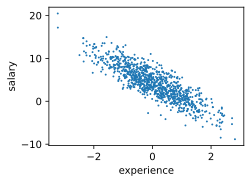

In [7]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);
# d2l.plt.xlabel('experience'); d2l.plt.ylabel('salary')


### 3.4 训练模型并预测结果
# 接下来，我们将使用线性回归模型对数据集进行建模。在这里，我们只需要定义一个输入大小为1的全连接层（`nn.Linear(1, 1)`）作为输出层。然后，我们可以像之前那样通过调用 `net` 函数来实例化该网络。最后，我们可以使用和之前相同的方式训练、验证和测试该模型：首先初始化权重参数；然后在每次迭代中计算损失值；最后更新权重参数。与上一节不同的是，由于此时特征向量 

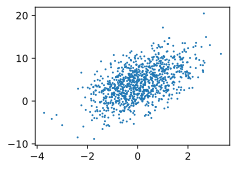

In [8]:
d2l.plt.scatter(features[:, (0)].detach().numpy(), labels.detach().numpy(), 1);

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)  # 以及生成好的feature数据，就可以知道有多少个样本
    # 随机读取样本的索引，这里是从0到num_examples-1,即总共有多少个样本，就生成多少个索引
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [17]:
batch_size = 10

i = 0
for X, y in data_iter(batch_size, features, labels):
    print("the list", i)
    print(X, '\n', y)
    i = i + 1
    

the list 0
tensor([[-0.3557, -0.5696],
        [-0.0954,  1.1151],
        [ 1.7687,  0.0808],
        [ 0.4688,  0.2424],
        [-0.1569,  0.5340],
        [-0.4298,  0.0190],
        [ 0.0652, -0.1412],
        [-1.0213,  0.3550],
        [ 1.9088,  0.5023],
        [-1.5246, -0.2661]]) 
 tensor([[5.4163],
        [0.2066],
        [7.4572],
        [4.3229],
        [2.0821],
        [3.2801],
        [4.8290],
        [0.9541],
        [6.3102],
        [2.0652]])
the list 1
tensor([[-0.7440,  1.7203],
        [-0.3371, -0.8491],
        [ 1.4344, -1.3287],
        [-0.1787,  0.2254],
        [ 1.4234,  0.7349],
        [ 0.3356, -0.6094],
        [-0.9102,  0.5587],
        [-1.4156, -0.8143],
        [ 1.0619,  2.3681],
        [ 2.0824, -0.4958]]) 
 tensor([[-3.1547],
        [ 6.3978],
        [11.5903],
        [ 3.0749],
        [ 4.5334],
        [ 6.9544],
        [ 0.4771],
        [ 4.1243],
        [-1.7245],
        [10.0726]])
the list 2
tensor([[-0.4362,  0.4943],
 

In [19]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0143],
         [-0.0022]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [20]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [21]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [22]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [23]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.041019
epoch 2, loss 0.000197
epoch 3, loss 0.000050


In [24]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0011, -0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)
